In [112]:
#导包
from netCDF4 import Dataset
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.utils import  plot_model
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd 
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import match
import xarray as xr
import os 
%matplotlib inline

In [2]:
# 检查可用GPU数量
len(tf.config.experimental.list_physical_devices('GPU'))

1

# 读取数据

## SSH

In [3]:
data_ssh = nc.Dataset(r'D:/codeFile/jupyterDemo/3d_ts/BPNN/data/SSH/SSH_2005-2015_month.nc')

In [4]:
time_ssh = data_ssh['time'][:]
print(len(time_ssh))

132


In [5]:
# 查看研究区域经纬度
ssh_lat = data_ssh['lat'][:].data
#print(ssh_lat[:])
ssh_lon = data_ssh['lon'][:].data
#print(ssh_lon[:])

In [6]:
ssh = data_ssh['ssh'][:].data
print(ssh.shape)

(132, 280, 600)


In [7]:
np.nanmax(ssh),np.nanmin(ssh)

(2.20051, -0.43673334)

## SSS

In [8]:
data_sss = nc.Dataset(r'D:/codeFile/jupyterDemo/3d_ts/BPNN/data/SSS/dataset-sss-ssd-rep-monthly_2005-2020.nc')

In [9]:
# 确定时间
time_sss = data_sss['time'][:132]
print(len(time_sss))

132


In [10]:
# 获取研究位置经纬度
sss_lat = data_sss['lat'][:].data
#print(sss_lat[:])
sss_lon = data_sss['lon'][:].data
#print(sss_lon[:])

In [11]:
sss = data_sss['sos'][:132].data 
print(sss.shape)
sss = np.squeeze(sss) # 移除大小为一的维度
print(sss.shape)

(132, 1, 280, 600)
(132, 280, 600)


In [12]:
np.nanmax(sss),np.nanmin(sss)

(36.072178, 13.604756)

## SSW

In [13]:
data_ssw = nc.Dataset(r'D:/codeFile/jupyterDemo/3d_ts/BPNN/data/SSW/anon_ssw_2005_2018_Month_data.nc')

In [14]:
# 确定时间
time_ssw = data_ssw['time'][:132]
print(len(time_ssw))

132


In [15]:
lat_ssw = data_ssw['lat'][:].data
#print(lat_ssw[314:594])
lon_ssw = data_ssw['lon'][:].data
#print(lon_ssw[440:1040])

# lat 0.125    ----    69.875
# lon  110.125    ----    259.875

In [16]:
uwnd = data_ssw['uwnd'][:132,314:594,440:1040].data  
vwnd = data_ssw['vwnd'][:132,314:594,440:1040].data

In [17]:
print(uwnd.shape)
print(vwnd.shape)

(132, 280, 600)
(132, 280, 600)


In [18]:
np.nanmax(uwnd),np.nanmin(uwnd),np.nanmax(vwnd),np.nanmin(vwnd)

(12.433594, -11.7988205, 8.8359995, -13.645481)

## 3DT

In [19]:
data_3dt_1 = nc.Dataset(r'D:/codeFile/jupyterDemo/3d_ts/BPNN/data/3DT/dataset-armor-3d-rep-monthly_2005-2009.nc')
data_3dt_2 = nc.Dataset(r'D:/codeFile/jupyterDemo/3d_ts/BPNN/data/3DT/dataset-armor-3d-rep-monthly_2010-2015.nc')

In [20]:
sst_1 = data_3dt_1['to'][:].data
sst_2 = data_3dt_2['to'][:].data

In [21]:
print(sst_1.shape)
print(sst_2.shape)

(60, 43, 280, 600)
(72, 43, 280, 600)


###  30 - 2000m 温度数据

In [22]:
temp_depth = np.append(sst_1,sst_2,axis=0)
print(temp_depth.shape)

(132, 43, 280, 600)


In [23]:
depths = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,125,150,175,200,225,250,275,300,350,400,
         450,500,550,600,700,800,900,1000,1100,1200,1300,1400,1500,1750,2000]
depths_use = [50,100,125,150,200,250,300,400,500,600,700,800,900,1000]

In [24]:
temp_depth_use = temp_depth[:,6:7]

In [25]:
for i,depth in enumerate(depths):
    if(depth in depths_use):
        #print(depths[i])
        temp_depth_use = np.concatenate((temp_depth_use,temp_depth[:,i:i+1]),axis=1)    

In [26]:
print(temp_depth_use.shape)
temp_depth_use = np.transpose(temp_depth_use, ( 0, 2,3,1))
print(temp_depth_use.shape)

(132, 15, 280, 600)
(132, 280, 600, 15)


### SST表面温度数据

In [27]:
sst = temp_depth[:,0:1,:,:]

In [28]:
sst = np.squeeze(sst)
print(sst.shape)

(132, 280, 600)


## 数据合并

In [29]:
print(ssh.shape,sss.shape,uwnd.shape,vwnd.shape,sst.shape)
cat_data =np.stack((ssh,sss,uwnd,vwnd,sst),axis=3)
cat_data.shape

(132, 280, 600) (132, 280, 600) (132, 280, 600) (132, 280, 600) (132, 280, 600)


(132, 280, 600, 5)

In [30]:
# 将表面数据和水下数据在最后一个维度拼接，将空值删除。
cat_data_ss_depth = np.concatenate((cat_data,temp_depth_use),axis=-1)

In [31]:
cat_data_ss_depth.shape 

(132, 280, 600, 20)

## 将两个温度异常区域的数据设置为nan

In [32]:
test = temp_depth_use[:,:,:,14:]
test[test < 0.4] = np.nan
test[test > 10] = np.nan

In [33]:
cat_data_ss_depth[:,:,:,19:] = test

In [34]:
cat_data_ss_depth.shape 

(132, 280, 600, 20)

## 去掉合并数据中的nan


In [35]:
## 先对合并的数据进行reshape成（长*宽，时间，通道）
cat_data_ss_depth_reshape  = np.transpose(cat_data_ss_depth,(1,2,0,3))
print(cat_data_ss_depth_reshape.shape)
cat_data_ss_depth_reshape = cat_data_ss_depth_reshape.reshape ((-1,132*20))
print(cat_data_ss_depth_reshape.shape)

(280, 600, 132, 20)
(168000, 2640)


In [36]:
# 将填充值赋值为nan
cat_data_ss_depth_reshape[cat_data_ss_depth_reshape == 32767] = np.nan
print('cat_data_ss_depth_reshape删除nan值之前',cat_data_ss_depth_reshape.shape)
# 使用 numpy.isnan 函数检测NaN值
nan_mask = np.isnan(cat_data_ss_depth_reshape)
# 通过布尔索引删除NaN值
cat_data_ss_depth_reshape_without_nan = cat_data_ss_depth_reshape[~nan_mask.any(axis=1)]   
# ~nan_mask.any(axis=1)只要第一个维度中含有False就会返回False
print('cat_data_ss_depth_reshape删除nan值之后',cat_data_ss_depth_reshape_without_nan.shape)

cat_data_ss_depth_reshape删除nan值之前 (168000, 2640)
cat_data_ss_depth_reshape删除nan值之后 (106050, 2640)


In [37]:
cat_data_ss_depth_reshape_without_nan = cat_data_ss_depth_reshape_without_nan.reshape(-1,132,20)
print(cat_data_ss_depth_reshape_without_nan.shape)
cat_data_ss_depth_reshape_without_nan = np.transpose(cat_data_ss_depth_reshape_without_nan,(1,0,2))
print(cat_data_ss_depth_reshape_without_nan.shape)

(106050, 132, 20)
(132, 106050, 20)


## 将数据进行堆叠

In [38]:
cat_data_ss_depth_reshape_without_nan.shape
cat_data = cat_data_ss_depth_reshape_without_nan[:,:,:5]
temp_depth_use = cat_data_ss_depth_reshape_without_nan[:,:,5:]
print(cat_data.shape,temp_depth_use.shape)

(132, 106050, 5) (132, 106050, 15)


In [39]:
available = len(cat_data) 
predict = 1

cat_data_shape = cat_data.shape[1:]
temp_depth_use_shape = temp_depth_use.shape[1:]

N_stack = 6  # 时间步长度

X_len = available - (N_stack-1)
Y_len = X_len

X = np.zeros(shape = (X_len, N_stack,cat_data_shape[0],cat_data_shape[1]))  
for i in range(X_len):
    X[i] = np.stack(cat_data[i:i+N_stack])
    #print(i)

Y = np.zeros(shape = (Y_len,predict,temp_depth_use_shape[0],temp_depth_use_shape[1]))
for i in range(Y_len):
    Y[i] = np.stack(temp_depth_use[i+N_stack-1 : i+N_stack-1+predict])
   # print(i+N_stack-1)

print(X.shape)
print(Y.shape)

(127, 6, 106050, 5)
(127, 1, 106050, 15)


# 验证集和测试集的划分

In [40]:
# 最后十二个月的数据作为test
test_num = 115
x_train = X[:test_num]
y_train = Y[:test_num]

x_test = X[test_num:]
y_test = Y[test_num:]

In [41]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape 

((115, 6, 106050, 5),
 (115, 1, 106050, 15),
 (12, 6, 106050, 5),
 (12, 1, 106050, 15))

## 修改维度

In [42]:
x_train = np.transpose(x_train, (0,2,1,3))   #(个数，尺度，时间，通道)
x_train = x_train.reshape((-1,6,5))          #(个数*尺度，时间，通道)

y_train = np.transpose(y_train, (0,2,1,3))
y_train = y_train.reshape((-1,1,15))

x_test = np.transpose(x_test, (0,2,1,3))
x_test = x_test.reshape((-1,6,5))

y_test = np.transpose(y_test, (0,2,1,3))
y_test = y_test.reshape((-1,1,15))
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(12195750, 6, 5) (12195750, 1, 15) (1272600, 6, 5) (1272600, 1, 15)


## 划分训练数据和目标数据

In [43]:
print('x_test.shape:',x_test.shape)
print('y_test.shape',y_test.shape)
print('x_train',x_train.shape)
print('y_train',y_train.shape)

x_test.shape: (1272600, 6, 5)
y_test.shape (1272600, 1, 15)
x_train (12195750, 6, 5)
y_train (12195750, 1, 15)


In [44]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

In [45]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((8537025, 6, 5),
 (1272600, 6, 5),
 (3658725, 6, 5),
 (8537025, 1, 15),
 (1272600, 1, 15),
 (3658725, 1, 15))

# 特征归一化

In [46]:
#y_test_shape

In [47]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape

In [48]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[2])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[2]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[2]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[2])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[2])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[2])) 

In [49]:
x_train = np.reshape(x_train,(x_train_shape))
x_test = np.reshape(x_test,(x_test_shape))
x_val = np.reshape(x_val,(x_val_shape))
y_train = np.reshape(y_train,(y_train_shape[0],-1))
y_test = np.reshape(y_test,(y_test_shape[0],-1))
y_val = np.reshape(y_val,(y_val_shape[0],-1))

In [50]:
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((8537025, 6, 5),
 (1272600, 6, 5),
 (3658725, 6, 5),
 (8537025, 15),
 (1272600, 15),
 (3658725, 15))

# 定义网络结构

In [51]:
#  model2_input= Input(shape=(6,5))
#     x2 = MHA1(model2_input,model2_input)
#     x2 = LSTM(64, return_sequences=True)(x2)   
#     x2 = Dropout(0.2)(x2)
    
#     x2 = MHA2(x2,x2)
#     x2 = LSTM(32, return_sequences=True)(x2)
#     x2 = Dropout(0.2)(x2)
# #
#     x2 = MHA3(x2,x2)
#     x2 = Flatten()(x2)
#     out2 = Dense(1)(x2)

In [52]:
#  MHA2 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=8)
#     MHA3 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=4)
    
    
#     model2_input= Input(shape=(6,5))

#     x2 = LSTM(64, return_sequences=True)(model2_input)   
#     x2 = Dropout(0.2)(x2)
    
#     mha2 = MHA2(x2,x2)
#     x2 = tf.keras.layers.Add()([x2, mha2])
#     x2 = Activation('relu')(x2)
    
#     x2 = LSTM(32, return_sequences=True)(x2)
#     #x2 = Dropout(0.2)(x2)
# #
#     mha3 = MHA3(x2,x2)
#     x2 = tf.keras.layers.Add()([x2, mha3])
#     x2 = Activation('relu')(x2)
#     x2 = Flatten()(x2)
#     out2 = Dense(1)(x2)
    

In [104]:
# def my_model():
# #     MHA1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=3)
#     MHA2 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)
# #     MHA3 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)
#     #MHA4 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=16)
    
#     model_input= Input(shape=(6,5))
    
# #     mha1 = MHA1(model_input,model_input)
# #     model = tf.keras.layers.Add()([model_input,mha1])
# #     model = tf.keras.layers.ReLU()(model)
    
#     model= LSTM(64, return_sequences=True)(model_input)   
#     model = Dropout(0.2)(model)
#     mha2 = MHA2(model,model)
#     model = tf.keras.layers.Add()([model,mha2])
#     model = tf.keras.layers.ReLU()(model)
    
#     model = LSTM(32, return_sequences=True)(model)
#     model = Dropout(0.2)(model)
# #     mha3 = MHA3(model,model)
# #     model = tf.keras.layers.Add()([model, mha3])
# #     model = tf.keras.layers.ReLU()(model)
    
# #     model_out = LSTM(32, return_sequences=True)(model)
# #     model = Dropout(0.3)(model)
# #     mha4 = MHA4(model,model)
# #     model = tf.keras.layers.Add()([model, mha4,model_out])
# #     model = tf.keras.layers.ReLU()(model)
    
    
#     model = Flatten()(model)
#     out = Dense(1)(model)
#     model = Model(inputs=model_input, outputs=out)
#     return model

In [113]:
# 注意力层的定制实现，以适应多次注意力调用
class Attention(Layer):
    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)
        
    def __call__(self, inputs):
        """
        Keras的多对一注意力机制。
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        """
        
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])  
        
        # Inside dense layer 内部全连接层
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W是可训练权重矩阵 
        
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states) 
        # 进行一次全连接，本质上没有太大意义，只是为了增加一下模型复杂度，
        # 并且改变一下前T个时间步的特征表示,这里其实也可以不进行全连接，直接使用hidden_states
        
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        # # 注意力，增加对最后一个时间步长的关注
        
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)  # 取出最后一个时间步的特征
        score = Dot(axes=[1, 2])([h_t, score_first_part])  # 将最后一个时间步长与前T个时间步长进行点积
        attention_weights = Activation('softmax')(score)   # 求权重（将权值通过softmax进行归一化，得到直接可用的权重）
        
        
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1])([hidden_states, attention_weights])  # 上下文向量
        pre_activation = Concatenate()([context_vector, h_t]) #再次将最后一个时间步的信息加入，本质上是一个残差连接，这步可以省略
        attention_vector = Dense(self.units, use_bias=False, activation='tanh')(pre_activation) # 用一个全连接层进行合并
        
        print('注意力被执行了一次')
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [116]:
def my_model():
    
    model_input= Input(shape=(6,5))
   
    model= LSTM(64, return_sequences=True)(model_input)   
    model = Dropout(0.2)(model)
    
    model = LSTM(32, return_sequences=True)(model)
    model = Attention()(model)
    
    model = Flatten()(model)
    
    out = Dense(1)(model)
    model = Model(inputs=model_input, outputs=out)
    return model

注意力被执行了一次


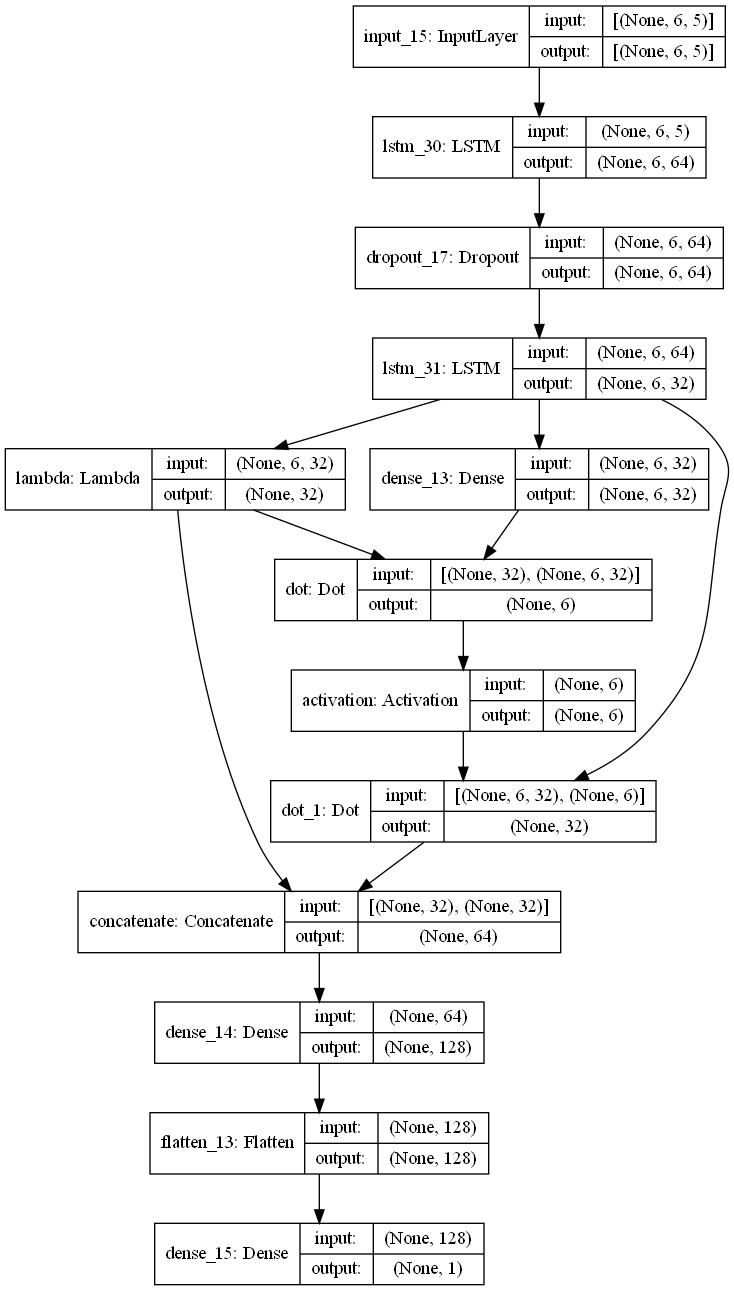

In [117]:
import graphviz
model = my_model()
#model.summary()
plot_model(model,show_shapes=True,show_layer_names=True)

In [118]:
# 创建神经网络模型
num_depths = 1
num_features = 5
# # 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
checkpoint_path='./LSTM_MHA_8.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [119]:
num_epochs = 1000
batch_size = 10240

history = model.fit(x_train, y_train[:,14:15], validation_data=(x_val,y_val[:,14:15]),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

Epoch 1/1000
834/834 - 8s - loss: 0.0642 - val_loss: 0.0310
Epoch 2/1000
834/834 - 6s - loss: 0.0296 - val_loss: 0.0247
Epoch 3/1000
834/834 - 6s - loss: 0.0256 - val_loss: 0.0228
Epoch 4/1000
834/834 - 6s - loss: 0.0237 - val_loss: 0.0213
Epoch 5/1000
834/834 - 6s - loss: 0.0224 - val_loss: 0.0203
Epoch 6/1000
834/834 - 6s - loss: 0.0215 - val_loss: 0.0195
Epoch 7/1000
834/834 - 6s - loss: 0.0207 - val_loss: 0.0188
Epoch 8/1000
834/834 - 6s - loss: 0.0201 - val_loss: 0.0185
Epoch 9/1000
834/834 - 6s - loss: 0.0196 - val_loss: 0.0181
Epoch 10/1000
834/834 - 6s - loss: 0.0191 - val_loss: 0.0178
Epoch 11/1000
834/834 - 6s - loss: 0.0188 - val_loss: 0.0173
Epoch 12/1000
834/834 - 6s - loss: 0.0184 - val_loss: 0.0171
Epoch 13/1000
834/834 - 6s - loss: 0.0181 - val_loss: 0.0170
Epoch 14/1000
834/834 - 6s - loss: 0.0179 - val_loss: 0.0165
Epoch 15/1000
834/834 - 6s - loss: 0.0176 - val_loss: 0.0163
Epoch 16/1000
834/834 - 6s - loss: 0.0174 - val_loss: 0.0161
Epoch 17/1000
834/834 - 6s - loss

## 网格搜索交叉验证寻找最佳参数

In [ ]:
# model = KerasRegressor(build_fn=create_model,verbose=2)

In [ ]:
# param_grid = {
#     'neurons': [15,30,50,100,150,200],
# }

In [ ]:
# # 使用GridSearchCV进行交叉验证并搜索最佳参数组合：
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# grid_result = grid_search.fit(x_train, y_train[:,14:15],epochs=200,verbose=2,batch_size=1024)

In [ ]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

## 训练30 - 1000m

In [ ]:
def train_model(x_train,y_train,x_val,y_val,name):
    # 创建网络
    model = my_model()
    # 编译网络
    model.compile(loss='mse', optimizer='adam')
    checkpoint_path=name
    keras_callbacks   = [
          EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
          ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
    ]
    model.fit(x_train, y_train, validation_data=(x_val,y_val),
                    epochs=1000, batch_size=1024, verbose=2, callbacks=keras_callbacks)

In [ ]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

In [ ]:
depth = [30,50,100,125,150,200,250,300,400,500,600,700,800,900,1000]

In [ ]:
# 训练30 - 1000m
for i in range(0,15):
    train_model(x_train,y_train[:,i:i+1],x_val,y_val[:,i:i+1],'./LSTM_model_'+str(depth[i])+'m.h5')

### 训练指定层

## 模型评估

In [87]:
# 评估函数定义
# 异常相关系数
import math
def acc(actual, predicted):
    pred_avg = np.average(predicted)

    act_avg = np.average(actual)
    diff_pred = predicted - pred_avg
    diff_act = actual - act_avg
    numerator = np.mean(np.sum(diff_pred*diff_act, axis=0))
    denominator = math.sqrt(np.mean(np.sum(diff_pred**2, axis=0)) * np.mean(np.sum(diff_act**2, axis=0)))
    ret_val = numerator/denominator
    return (100 * ret_val)


# 查看损失
def look_loss(history):
    plt.figure(figsize=(6.3, 2.5), dpi = 100)
    plt.plot(history.history['loss'], label='training data')
    plt.plot(history.history['val_loss'], label='validation data')
    plt.title('Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Number of epochs')
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()


# 模型预测
def all_estimate(best_model,x_test,y_test):
    testPred_1 = best_model.predict(x_test)
    a = y_test
    y_test_p = a.reshape(-1,1)
    testPred_p = testPred_1.reshape(-1,1)


    rmse = sqrt(mean_squared_error(y_test_p,testPred_p))
    print('Test RMSE: %.3f' % rmse)

    print('acc:',acc(y_test_p,testPred_p))

    r2 = r2_score(y_test_p,testPred_p)
    print("R² score:", r2)  
    

def respective_estimate(best_model,x_test,y_test):
    re2_list = []
    rmse_list = []
    for i in range(6):
        # 模型预测
        testPred = best_model.predict(x_test[i:i+1])
        a = y_test[i:i+1]
        y_test_p = a.reshape(-1,1)
        testPred_p = testPred.reshape(-1,1)
        r2 = r2_score(y_test_p,testPred_p)
        rmse = sqrt(mean_squared_error(y_test_p,testPred_p))
        re2_list.append(r2)
        rmse_list.append(rmse)    
    return re2_list,rmse_list

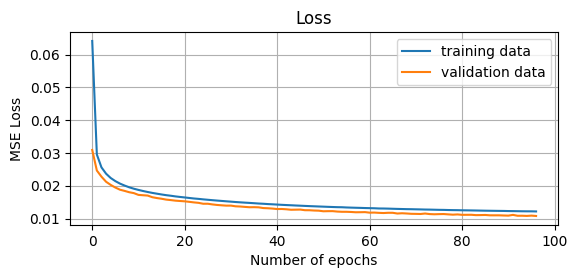

In [120]:
look_loss(history)

### 对指定层进行评估

In [121]:
best_model = tf.keras.models.load_model('LSTM_MHA_8.h5')
all_estimate(best_model,x_test,y_test[:,14:15])

Test RMSE: 0.172
acc: 98.5224902051825
R² score: 0.970387885196331


### 对所有层进行评估

In [ ]:
# 模型预测
for i in range(0,15):
    best_model = tf.keras.models.load_model('LSTM_model_'+str(depth[i])+'m.h5')
    print(str(depth[i])+'测试集：')
    all_estimate(best_model,x_test,y_test[:,i:i+1])
# re2_list,rmse_list = respective_estimate(best_model,x_test,y_test[:,:,:,:,0:5])
# re2_list,rmse_list

# 保存预测结果

In [ ]:
# 模型预测
result = [] 
for i in range(0,15):
    best_model = tf.keras.models.load_model('LSTM_model_'+str(depth[i])+'m.h5')
    #print('预测第'+str(depth[i]+'m的温度')
    testPred = best_model.predict(x_test)
    result.append(testPred)

In [ ]:
result = np.array(result)
print(result.shape)
result = np.transpose(result,(1,2,0))
print(result.shape)
result = result.reshape(-1,15)
print(result.shape)

## 对预测结果进行反归一化

In [ ]:
y_test = y_test.reshape(-1,15)

In [ ]:
result.shape,y_test.shape 

In [ ]:
result_unscaled = scaler_l.inverse_transform(result)
y_test_unscaled = scaler_l.inverse_transform(y_test)

## 评估反归一化之后的结果

In [ ]:
for i in range(0,15):
    r2 = r2_score(y_test_unscaled[:,i],result_unscaled[:,i])
    print(str(depth[i])+'m R² score:',r2)

In [ ]:
for i in range(0,15):
    mse =  mean_squared_error(y_test_unscaled[:,i],result_unscaled[:,i])
    print(str(depth[i])+'m Test mse: %.3f' % mse)

# 预测结果可视化

## 为归一化之后的预测值和真实值填充nan

In [ ]:
cat_data_ss_depth_test = np.transpose(cat_data_ss_depth,(1,2,0,3))
print(cat_data_ss_depth_test.shape)
cat_data_ss_depth_test = cat_data_ss_depth_test.reshape ((-1,132*20))
print(cat_data_ss_depth_test.shape)

In [ ]:
cat_data_ss_depth_test[cat_data_ss_depth_test == 32767] = np.nan
print('cat_data_ss_depth_test删除nan值之前',cat_data_ss_depth_test.shape)
# 使用 numpy.isnan 函数检测NaN值
nan_mask = np.isnan(cat_data_ss_depth_test)

In [ ]:
nan_mask[nan_mask.any(axis=1) == True] = True   # nan为True,只要有一个通道存在nan,就都设置为nan
nan_masks = nan_mask[:,1]    #得到图像的masks

In [ ]:
### 创建一个形状与nan_masks相同且全是nan的数组
testPred_with_nan = np.full((168000,12*15), np.nan)  
print(testPred_with_nan.shape)

y_test_with_nan = np.full((168000,12*15), np.nan)  
print(y_test_with_nan.shape)

In [ ]:
result_unscaled_reshape = result_unscaled.reshape(12,-1,15)
print(result_unscaled_reshape.shape)
result_unscaled_reshape = np.transpose(result_unscaled_reshape,(1,0,2))
print(result_unscaled_reshape.shape)
result_unscaled_reshape = result_unscaled_reshape.reshape(-1,12*15)
print(result_unscaled_reshape.shape)

# ======================================== #
y_test_unscaled_reshape = y_test_unscaled.reshape(12,-1,15)
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = np.transpose(y_test_unscaled_reshape,(1,0,2))
print(y_test_unscaled_reshape.shape)
y_test_unscaled_reshape = y_test_unscaled_reshape.reshape(-1,12*15)
print(y_test_unscaled_reshape.shape)


In [ ]:
y_test_unscaled.shape 

In [ ]:
num = 0
for i,nan_mask in enumerate(nan_masks):   # i从0开始

    if (nan_mask == False): # False 代表没有nan，使用预测值进行填充
        testPred_with_nan[i] = result_unscaled_reshape[num]
        y_test_with_nan[i] = y_test_unscaled_reshape[num]
        num = num + 1
        
print(num)

In [ ]:
testPred_with_nan = testPred_with_nan.reshape(280, 600,12,15)
testPred_with_nan = np.transpose(testPred_with_nan,(2,3,0,1))


y_test_with_nan = y_test_with_nan.reshape(280, 600,12,15)
y_test_with_nan = np.transpose(y_test_with_nan,(2,3,0,1))

print(testPred_with_nan.shape,y_test_with_nan.shape)

# 结果可视化

In [ ]:
lat = []
lon = []
time = []

In [ ]:
lon.append(data_ssh['lon'][:].data)
lat.append(data_ssh['lat'][:].data)

In [ ]:
start_year = 2015
end_year =2015
time = []
date_range = pd.date_range(datetime(start_year,1,1),datetime(end_year+1,1,1),freq='1M')
len(date_range)
for i in range(len(date_range)):
    time.append(i)

In [ ]:
new_NC.close()

In [ ]:
new_NC = nc.Dataset("result30_1000m_LSTM.nc", 'w', format='NETCDF4')

'''
定义维度，后一个参数表示维度的长度，因为是合并的同一个产品的数据，所以是统一
的,注意维度的长度一定要和读入的数据匹配
'''

new_NC.createDimension('lat', len(lat[0]))
new_NC.createDimension('lon', len(lon[0]))
new_NC.createDimension('true_sta', len(y_test_with_nan))
new_NC.createDimension('pred_sta', len(testPred_with_nan))

new_NC.createDimension('depth', 15)
new_NC.createDimension('time', len(time))




new_NC.createVariable('lat', 'f', ("lat"))
new_NC.createVariable('lon', 'f', ("lon"))
new_NC.createVariable('depth', 'f', ("depth"))
new_NC.createVariable('true_sta', 'f',("time","depth","lat","lon"))
new_NC.createVariable('pred_sta', 'f',("time","depth","lat","lon"))

time_var = new_NC.createVariable('time', 'f4',("time"))
time_var.units = 'months since 2015-01-15'
time_var.long_name = 'Months in Monthly Means'
time_var.axis = 'T'



#向变量中填充数据
new_NC.variables['lat'][:] = lat[0]
new_NC.variables['lon'][:] = lon[0]
new_NC.variables['time'][:] = np.array(time)
new_NC.variables['depth'][:] = depth

new_NC.variables['true_sta'][:]=np.array(y_test_with_nan)
new_NC.variables['pred_sta'][:]=np.array(testPred_with_nan)


#最后记得关闭文件
new_NC.close()


In [ ]:
depth